# Temporal CNN with uncertainty

In this tutorial, we show how to quickly set up and train an CNN regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting.

In [116]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.metrics as metrics
from pandas import read_table

%matplotlib inline

## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [293]:
step_size = 1/24
time_start = 0.0
time_end = 365.0
time = np.arange(time_start, time_end, step_size)

f1 = 1.0
f2 = 0.75
sigma1 = 1
sigma2 = 1
y_deter = (np.sin(2*np.pi*f1*time)*(1.0 + np.cos(2*np.pi*f2*time)))
y_stoch = sigma1*np.random.randn(len(time)) + sigma2*np.random.standard_t(5, len(time))*np.sin(2*np.pi*f1*time)
y = y_deter*y_stoch

data = np.expand_dims(y,0)
data = np.expand_dims(data,2)

holdout = 24*14
train_data = data[:,:-holdout,:]
test_data = data[:,-holdout:,:]

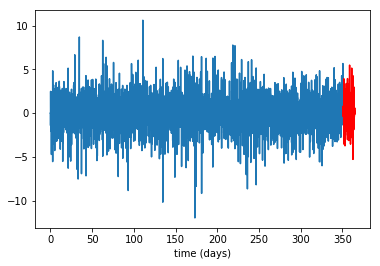

In [294]:
# Let plot the data
plt.plot(time[:-holdout], train_data[0,:,0])
plt.plot(time[-holdout:], test_data[0,:,0], 'r-')
plt.xlabel('time (days)')
plt.show()

## Topology for CNN

Here, we are simply stacking a few convolutional layers on top of each other to build a deep architecture. 

In [295]:
topology = [
    {
        'meta': {
            'layer_type': 'Conv1D',
            'layer_id': 'conv1',
            'parent_ids': ['input']
        },
        'params': {
            'filters': 128,
            'kernel_size': 6,
            'activation': 'elu'
        }
    },
    {
        'meta': {
            'layer_type': 'Conv1D',
            'layer_id': 'conv2',
            'parent_ids': ['conv1']
        },
        'params': {
            'filters': 64,
            'kernel_size': 5,
            'activation': 'elu'
        }
    },
    {
        'meta': {
            'layer_type': 'Conv1D',
            'layer_id': 'conv3',
            'parent_ids': ['conv2']
        },
        'params': {
            'filters': 32,
            'kernel_size': 4,
            'activation': 'elu'
        }
    },
    {
        'meta': {
            'layer_type': 'Flatten',
            'layer_id': 'flat1',
            'parent_ids': ['conv3']
        },
        'params': {}
    },
    {
        'meta': {
            'layer_type': 'Dense',
            'layer_id': 'dense1',
            'parent_ids': ['flat1']
        },
        'params': {
            'units': 64,
            'activation': 'elu'
        }
    },
    {
        'meta': {
            'layer_type': 'Dense',
            'layer_id': 'dense2',
            'parent_ids': ['dense1']
        },
        'params': {
            'units': 128,
            'activation': 'elu'
        }
    }
]

Let's fit the forecaster!

In [296]:
forecaster = Forecaster(
    topology,
    lag=24*28,  # This is the number of time steps used to predict the future for each data point
    horizon=24*14,  # This is how many time steps into the future we want to produce
    optimizer='nadam',  # Which optimizer the forecaster is using
    loss='heteroscedastic_gaussian', 
    dropout_rate=0.1,
    lr=0.001,  # This is the learning rate for the optimizer
    max_epochs=50  # Maximum number of epochs that the optimizer will perform
)

The target variable here denotes the index of the target time series, we are trying to forecast.

In [297]:
forecaster.fit(train_data, patience=10, verbose=1)  # patience is the number of epochs to wait until early stopping is executed

Train on 6676 samples, validate on 741 samples
Epoch 1/50
6676/6676 [==============================] - 14s 2ms/step - loss: -0.8786 - val_loss: -1.2281
Epoch 2/50
6676/6676 [==============================] - 8s 1ms/step - loss: -1.4631 - val_loss: -1.5649
Epoch 3/50
6676/6676 [==============================] - 9s 1ms/step - loss: -1.7019 - val_loss: -1.6656
Epoch 4/50
6676/6676 [==============================] - 9s 1ms/step - loss: -1.8384 - val_loss: -1.7794
Epoch 5/50
6676/6676 [==============================] - 9s 1ms/step - loss: -1.8984 - val_loss: -1.8452
Epoch 6/50
6676/6676 [==============================] - 9s 1ms/step - loss: -1.9582 - val_loss: -1.7571
Epoch 7/50
6676/6676 [==============================] - 9s 1ms/step - loss: -1.9955 - val_loss: -1.9353
Epoch 8/50
6676/6676 [==============================] - 9s 1ms/step - loss: -2.0398 - val_loss: -1.9757
Epoch 9/50
6676/6676 [==============================] - 9s 1ms/step - loss: -2.0654 - val_loss: -1.8916
Epoch 10/50
6676

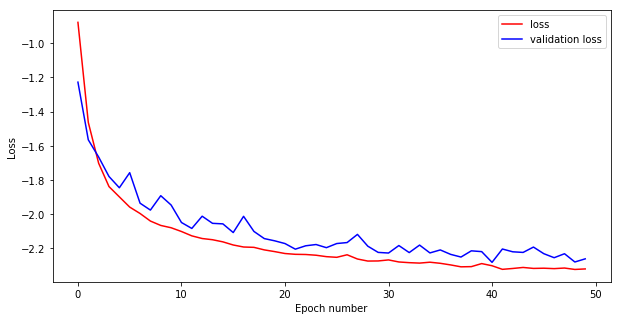

In [298]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'blue') 
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(['loss', 'validation loss'])

As before, we can use the forecaster to make predictions

In [299]:
predictions = forecaster.predict(data=train_data, n_samples=10000)


In [300]:
print('MSE: {}'.format(round(metrics.mse(predictions['mean'], test_data[:,:,:1]), 2)))
print('MAPE: {}%'.format(round(metrics.mape(predictions['mean'], test_data[:,:,:1]), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(predictions['mean'], test_data[:,:,:1]), 2)))

MSE: 1.31
MAPE: 385896667891974.75%
SMAPE: 178.97%


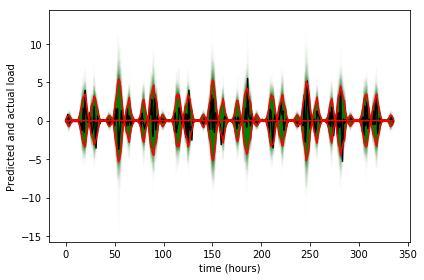

In [304]:
# We're printing the test set data and the predictions for the load data

plt.plot(predictions['samples'][::10,0,:,0].T, 'g', alpha=0.01)
plt.plot(test_data[0,:,0].T, 'k')
plt.plot(predictions['mean'][0,:,0], 'r')
plt.plot(predictions['lower_quantile'][0,:,0], 'r-')
plt.plot(predictions['upper_quantile'][0,:,0], 'r-')
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()

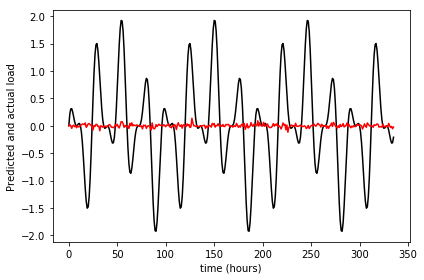

In [302]:
# We're printing the test set data and the predictions for the load data

plt.plot(y_deter[-holdout:], 'k')
plt.plot(predictions['mean'][0,:,0], 'r')
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()